**Mount the Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Unzip the Data**

In [0]:
!unzip '/content/gdrive/My Drive/MonuSegPatch.zip'

Archive:  /content/gdrive/My Drive/MonuSegPatch.zip
replace ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH1.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH10.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH11.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH12.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH13.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH14.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH15.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH16.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A

**Set the tensorflow to the to 1.x version**

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import the libraries**

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.layers import Layer, ZeroPadding2D, Cropping2D
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model
from keras.layers import Layer

Using TensorFlow backend.


**Parameters for Image Resolution**

In [0]:
im_width = 256
im_height = 256

**Function to load Images and Masks**

In [0]:
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder
  im_width, im_height = im_shape
  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))
  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

**Load the training images and mask**

In [0]:
X, y = get_images("/content/ModMonuSeg/Training/", (im_width, im_height))

No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


**Split the training data into training and validation**

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

**Visualize any random image along with the mask**

Text(0.5, 1.0, 'GroundTruth')

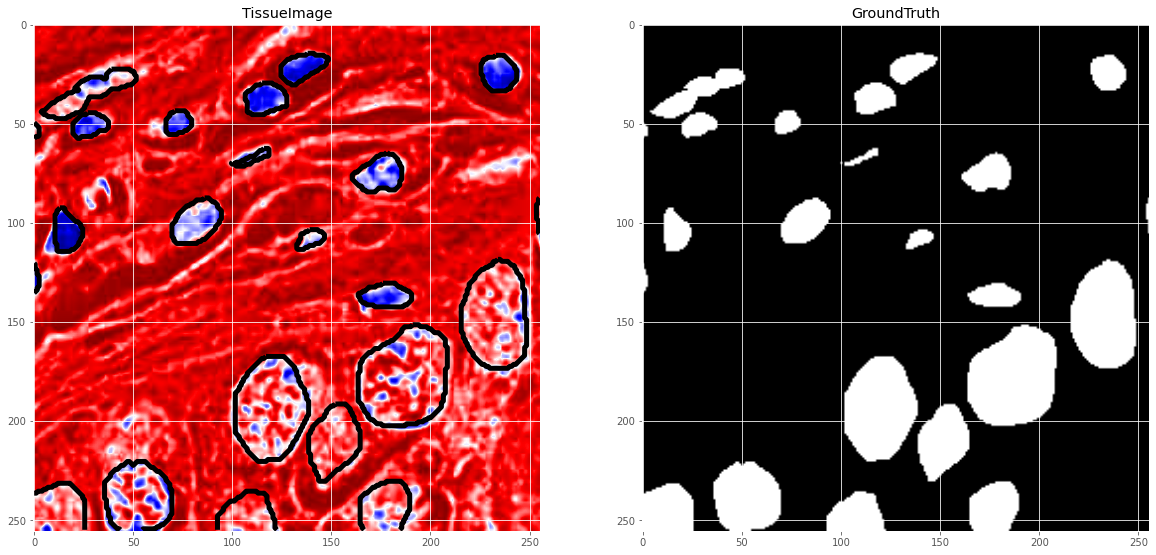

In [0]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() >
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TissueImage')
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

**Define the SEGNET Model Function**

In [0]:
class MaxPooling2DWithIndices(Layer):
    def __init__(self, pool_size, strides, padding='SAME', **kwargs):
        super(MaxPooling2DWithIndices, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        return

    def call(self, x):
        pool_size = self.pool_size
        strides = self.strides
        if isinstance(pool_size, int): ps = [1, pool_size, pool_size, 1]
        else: ps = [1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int): st = [1, strides, strides, 1]
        else: st = [1, strides[0], strides[1], 1]
        mpooled, indices = tf.nn.max_pool_with_argmax(x, ps, st, self.padding)
        return [mpooled, indices]

    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape = (input_shape[0], input_shape[1]//self.pool_size, input_shape[2]//self.pool_size, input_shape[3])
        else: output_shape = (input_shape[0], input_shape[1]//self.pool_size[0], input_shape[2]//self.pool_size[1], input_shape[3])
        return [output_shape,output_shape]

class MaxUnpooling2DWithIndices(Layer):
    def __init__(self, **kwargs):
        super(MaxUnpooling2DWithIndices, self).__init__(**kwargs)
        return
        
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(tf.matmul(K.reshape(tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output

    def compute_output_shape(self, input_shape):
        return input_shape[0][0],input_shape[0][1]*2,input_shape[0][2]*2,input_shape[0][3]

class SegNet:
    def __init__(self, depth = 64):
        self.depth = depth

    def CompositeConv2D(self, input_layer, num_convs, filters):
        output = input_layer
        for i in range(num_convs):
            output = Conv2D(filters, kernel_size=(3, 3), padding='same', activation="relu")(output)
            output = BatchNormalization(axis=3)(output)
        return output
        
    def encoder(self, input_layer):
        encoded_out = self.CompositeConv2D(input_layer, 2, self.depth)
        encoded_out, indices1 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 2, self.depth)
        encoded_out, indices2 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 3, self.depth)
        encoded_out, indices3 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 3, self.depth)
        encoded_out, indices4 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 3, self.depth)
        encoded_out, indices5 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        return [encoded_out, indices1, indices2, indices3, indices4, indices5]

    def decoder(self, encoded_out, indices1, indices2, indices3, indices4, indices5):
        decoded_out = MaxUnpooling2DWithIndices()([encoded_out, indices5])
        decoded_out = self.CompositeConv2D(decoded_out, 3, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices4])
        decoded_out = self.CompositeConv2D(decoded_out, 3, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices3])
        decoded_out = self.CompositeConv2D(decoded_out, 3, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices2])
        decoded_out = self.CompositeConv2D(decoded_out, 2, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices1])
        decoded_out = self.CompositeConv2D(decoded_out, 2, self.depth)
        
        return decoded_out

    def SegNet(self, input_shape):
        self.depth = 40;
        input_layer = Input(shape=input_shape)
        encoded_out, indices1, indices2, indices3, indices4, indices5 = self.encoder(input_layer)
        decoded_out = self.decoder(encoded_out, indices1, indices2, indices3, indices4, indices5)
        decoded_out = Conv2D(1, kernel_size=(3, 3), padding="same", activation="sigmoid")(decoded_out)
        model = Model(input_layer, decoded_out)
        return model

**Define the functions of Dice, Precision, Recall and F1**

In [0]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Set Parameters and compile the model**

In [0]:
model = SegNet().SegNet(input_shape=(X_train[0].shape))
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1_m])

**To save model, Early Stopping and Reduce Learning rate use callbacks**

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Segnet.h5', verbose=1, save_best_only=False, save_weights_only=True)
]

**Model Summary**

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 40) 1120        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 40) 160         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 40) 14440       batch_normalization_1[0][0]      
____________________________________________________________________________________________

**Train the model**

In [0]:
results=model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 972 samples, validate on 108 samples
Epoch 1/50
972/972 [==============================] - 65s 66ms/step - loss: 0.6178 - acc: 0.6775 - dice_coef: 0.8576 - f1_m: 0.5332 - val_loss: 3.3965 - val_acc: 0.6030 - val_dice_coef: 0.8193 - val_f1_m: 0.3849

Epoch 00001: saving model to model-Segnet.h5
Epoch 2/50
972/972 [==============================] - 54s 55ms/step - loss: 0.4315 - acc: 0.8233 - dice_coef: 0.9161 - f1_m: 0.6771 - val_loss: 2.5778 - val_acc: 0.6610 - val_dice_coef: 0.8451 - val_f1_m: 0.4947

Epoch 00002: saving model to model-Segnet.h5
Epoch 3/50
972/972 [==============================] - 54s 55ms/step - loss: 0.3799 - acc: 0.8369 - dice_coef: 0.9285 - f1_m: 0.6874 - val_loss: 0.6795 - val_acc: 0.7797 - val_dice_coef: 0.8970 - val_f1_m: 0.6664

Epoch 00003: saving model to model-Segnet.h5
Epoch 4/50
972/972 [==============================] - 54s 55ms/step - loss: 0.3617

**Graph between Training and Validation Loss**

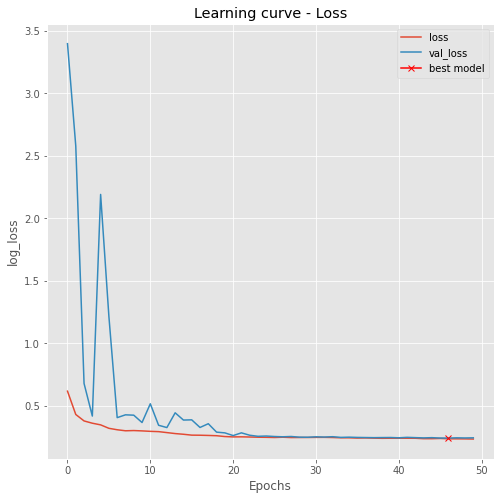

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Loss")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Graph between Training and Validation Accuracy**

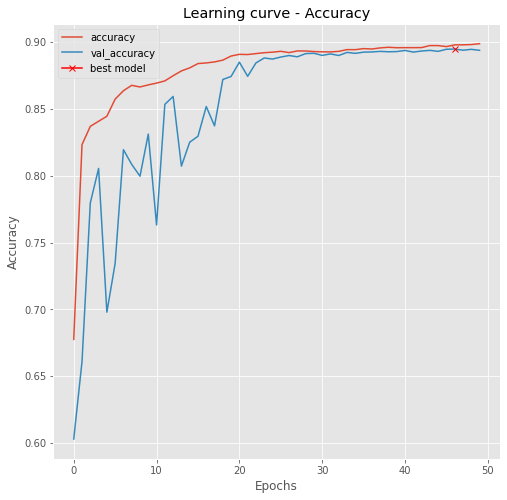

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Accuracy")
plt.plot(results.history["acc"], label="accuracy")
plt.plot(results.history["val_acc"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

**Graph between Training and Validation Dice**

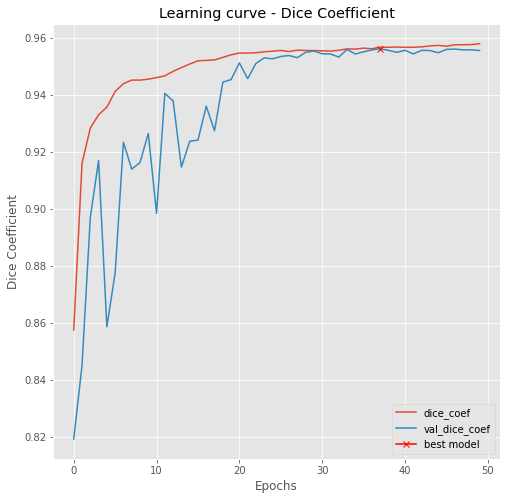

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Dice Coefficient")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend();

**Graph between Training and Validation F1 score**

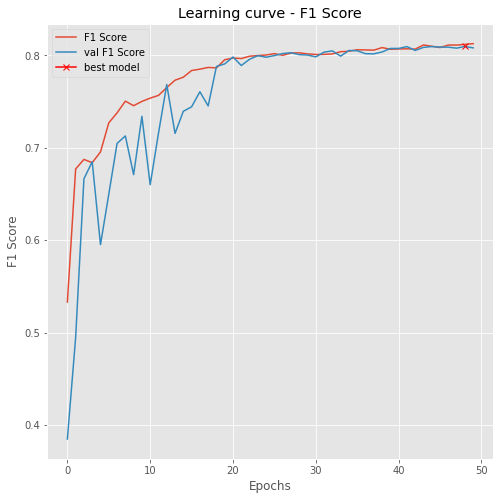

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - F1 Score")
plt.plot(results.history["f1_m"], label="F1 Score")
plt.plot(results.history["val_f1_m"], label="val F1 Score")
plt.plot( np.argmax(results.history["val_f1_m"]), np.max(results.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend();